# Population Inference on GWTC-3

Adapted from the example from [gwpopulation](https://github.com/ColmTalbot/gwpopulation)


# Agenda
1. Take all the BBH events in The thrid gravitational-wave transient catalog [GWTC-3](https://arxiv.org/abs/1811.12907)

   This includes all compact binary coalescences observed during Advanced LIGO/Virgo's first three oberving runs.

1. Define a population model for the mass distributions (primary mass, mass ratio)

1. Carry out a hierarchical inference to infer the hyper-parameters of the mass model.



# Tools

1. `GWPopulation`. simple, modular, user-friendly, population inference. Mass, spin, redshift models defined here.
1. Sampling and the language of [Bilby](https://git.ligo.org/lscsoft/bilby) ([arXiv:1811.02042](https://arxiv.org/abs/1811.02042)) 

# This exercise

- Use a mass distribution in primary mass and mass ratio from Talbot & Thrane (2018) ([arXiv:1801:02699](https://arxiv.org/abs/1801.02699)).
- Equivalent to the `PowerLaw + Peak` model used in LVK analyses without the low-mass smoothing for computational efficiency.


## Also existant
- [Implemented models](https://colmtalbot.github.io/gwpopulation/_autosummary/gwpopulation.models.html#module-gwpopulation.models).
- Half-Gaussian + isotropic spin tilt distribution from Talbot & Thrane (2017) ([arXiv:1704.08370](https://arxiv.org/abs/1704.08370)).
- Beta spin magnitude distribution from Wysocki+ (2018) ([arXiv:1805:06442](https://arxiv.org/abs/1805.06442)).
- Each of these are also available with independent but identically distributed spins.
- Redshift evolution model as in Fishbach+ (2018) ([arXiv:1805.10270](https://arxiv.org/abs/1805.10270)).
- Can implement custom models.

# Setup

## Google collab
1. Choose a GPU-accelerated runtime (e.g. T4 GPU).

"runtime"->"change runtime type"->"Hardware accelerator = GPU"


### Install some needed packages

All of the dependencies for this are integrated into `GWPopulation`.
These include `Bilby` and `dynesty` for sampling.

In [ ]:
!pip install gwpopulation --quiet --progress-bar off

In [ ]:
!gdown https://drive.google.com/uc?id=16gStLIjt65gWBkw-gNOVUqNbZ89q8CLF
!gdown https://drive.google.com/uc?id=10pevUCM3V2-D-bROFEMAcTJsX_9RzeM6

/bin/bash: line 1: gdown: command not found
/bin/bash: line 1: gdown: command not found



## Personal laptop

1. Install anaconda (if you dont have)
1. Use the [environment file] to create a conda environment


        `conda env create -f n3pm_env.yml`

1. Downliad the above files using the urls to your notebook directory

## Download data

We need to download the data for the events and simmulated "injections" used to characterize the detection sensitivity.

### Event posteriors

We're using the posteriors from the GWTC-3 data release in a pre-processed format.

The file was produced by [gwpopulation-pipe](https://docs.ligo.org/ratesAndPopulations/gwpopulation_pipe) to reduce the many GB of posterior sample files to a single ~30Mb file.

The choice of events in this file was not very careful and should only be considered qualitatively correct.

The data file can be found [here](https://drive.google.com/drive/folders/1wyfR6sYvYVdBefF9_vrVTp0Btu03OlzL?usp=drive_link).
The original data can be found at [zenodo:5546663](https://zenodo.org/records/5546663) and [zenodo:6513631](https://zenodo.org/records/6513631) along with citation information.

### Sensitivity injections

Again I have pre-processed the full injection set using `gwpopulation-pipe` to reduce the filesize.
The original data is available at [zenodo:7890398](https://zenodo.org/records/7890398) along with citation information.

## Imports

Import the packages required for the script.
We also set the backend for array operations to `jax` which allows us to take advantage of just-in-time (jit) compilation in addition to GPU-parallelisation when available.

In [1]:
import bilby as bb
import gwpopulation as gwpop
import jax
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
import numpy as np

gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

## Load posteriors

We remove two events from the file that shouldn't be there that have NS-like secondaries as we are just interested in BBHs for this demonstration.

In [2]:
posteriors = pd.read_pickle("gwtc-3-samples.pkl")
del posteriors[15]
del posteriors[38]

## Load injections

Load the injections used to characterize the sensitivity of the gravitaitonal-wave survey.

In [3]:
import dill

with open("gwtc-3-injections.pkl", "rb") as ff:
    injections = dill.load(ff)

## Define some models and the likelihood

We need to define `Bilby` `Model` objects for the numerator and denominator independently as these cache some computations interally.

We create a model that uses a cosmology fixed to the Planck 2015 values for flat Lambda CDM.

The `HyperparameterLikelihood` marginalises over the local merger rate, with a uniform-in-log prior.
The posterior for the merger rate can be recovered in post-processing.

We provide:

- `posteriors`: a list of `pandas` DataFrames.
- `hyper_prior`: our population model, as defined above.
- `selection_function`: anything which evaluates the selection function.

We can also provide:

- `conversion_function`: this converts between the parameters we sample in and those needed by the model, e.g., for sampling in the mean and variance of the beta distribution.
- `max_samples`: the maximum number of samples to use from each posterior, this defaults to the length of the shortest posterior.

In [4]:
model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
    ],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
)

## Define our prior

The mass model has eight parameters that we vary that are described in arXiv:1801:02699. This model is sometimes referred to as "PowerLaw+Peak"

The spin magnitude model is a `Beta` distribution with the usual parameterization, and the spin orientation model is a mixure of a uniform component and a truncated Gaussian that peaks at aligned spin. This combination is sometimes referred to as "Default".

For redshift we use a model that looks like

$$p(z) \propto \frac{d V_{c}}{dz} (1 + z)^{λ - 1}$$

In [ ]:
priors = PriorDict()

# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100

# spin
priors["amax"] = 1
priors["alpha_chi"] = 3 #Uniform(minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$")
priors["beta_chi"] = 4 # Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = 0.7# Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = 3# Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")


priors["lamb"] = 7 #niform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

## Just-in-time compile using JAX

JIT compile the likelihood object before starting the sampler, using `gwpopulation.experimental.jax.JittedLikelihood` class.

In [6]:
parameters = priors.sample()

In [7]:
parameters

{'alpha': -0.9112784436044281,
 'beta': 10.707901021971301,
 'mmin': 2.490301957647063,
 'mmax': 99.10512067450469,
 'lam': 0.7973084921979398,
 'mpp': 22.57669757826582,
 'sigpp': 7.123616235030236,
 'gaussian_mass_maximum': 100.0,
 'amax': 1.0,
 'alpha_chi': 3.0,
 'beta_chi': 4.0,
 'xi_spin': 0.7,
 'sigma_spin': 3.0,
 'lamb': 7.0}

In [14]:
red_pars = {'alpha': 0.3949072658140942,
             'beta': -0.9347469576470306,
             'mmin': 2.314923073404898,
             'mmax': 99.30823964844406,
             'lam': 0.551015290765012,
             'mpp': 34.07791899483966,
             'sigpp': 3.5147064761229663,
             'gaussian_mass_maximum': 100.0,}


dataset = {"mass_1" : np.arange(10, 100, 1/10),
           "mass_ratio" : np.arange(0.1, 1, 1/10)}

In [16]:
#pdist = gwpop.models.mass.two_component_primary_mass_ratio(dataset, **red_pars)
Marr = np.linspace(10, 100, 100)

pdist = gwpop.models.mass.two_component_single(mass=Marr,
                                               alpha=0.29,
                                               mmin=2.31,
                                               mmax=99.3,
                                               lam=0.55,
                                               mpp=34,
                                               sigpp=3.5)

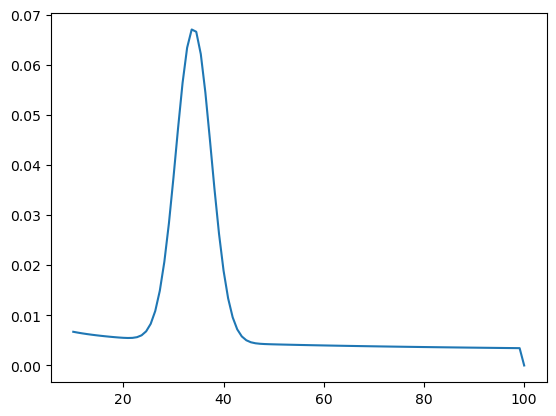

In [17]:
plt.plot(Marr, pdist)

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,prior
22905,23.684590,0.219608,0.961273,0.340220,0.465789,-0.207763,0.062695,0.071553
107482,26.720620,0.157377,0.638495,0.189577,0.873222,-0.795118,0.133186,0.362019
75908,15.619926,0.439098,0.396459,0.073777,0.807164,0.305151,0.092790,0.103173
120291,14.414318,0.508565,0.270675,0.624814,0.522184,0.810375,0.101050,0.112838
58398,20.377419,0.266791,0.849056,0.846184,0.388742,0.572950,0.107231,0.179510
...,...,...,...,...,...,...,...,...
114920,12.626520,0.623092,0.943090,0.588203,0.083436,0.459074,0.119740,0.138508
89942,13.778607,0.534322,0.790983,0.019945,0.313088,-0.922897,0.112408,0.133315
100109,14.480536,0.524394,0.278312,0.309670,0.680513,0.721477,0.068338,0.051957
63216,17.629880,0.337476,0.591703,0.217676,0.694875,-0.870138,0.116534,0.183244


In [22]:

likelihood.parameters.update(parameters)


likelihood.log_likelihood_ratio()
print("Usual evaluation")
%time print(likelihood.log_likelihood_ratio())


jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)

print("JAX implementation")
print("1st eval")
%time print(jit_likelihood.log_likelihood_ratio())
print(" Subsequent evals")
%time print(jit_likelihood.log_likelihood_ratio())

Usual evaluation
-319.8966819252214
CPU times: user 315 ms, sys: 67.4 ms, total: 382 ms
Wall time: 208 ms
JAX implementation
1st eval
-319.8966819252214
CPU times: user 3.4 s, sys: 334 ms, total: 3.73 s
Wall time: 3.23 s
 Subsequent evals
-319.8966819252214
CPU times: user 86.9 ms, sys: 7.96 ms, total: 94.9 ms
Wall time: 22.1 ms


## Run the sampler

We'll use the sampler `dynesty` and use a small number of live points to reduce the runtime (total runtime should be approximately 5 minutes on T4 GPUs via Google colab).
The settings here may not give publication quality results, a convergence test should be performed before making strong quantitative statements.

`bilby` times a single likelihood evaluation before beginning the run, however, this isn't well defined with JAX.

**Note:** sometimes this finds a high likelihood mode, likely due to [breakdowns in the approximation](https://arxiv.org/abs/2304.06138) used to estimate the likelihood. If you see `dlogz > -190`, you should interrupt the execution and restart.

In [23]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=500,
    sample="acceptance-walk",
    naccept=5,
    save="hdf5",
    outdir="hierarchical",
    label="mass_500"
)

09:57 bilby INFO    : Running for label 'mass_500', output will be saved to 'hierarchical'
09:57 bilby INFO    : Analysis priors:
09:57 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
09:57 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
09:57 bilby INFO    : mmin=Uniform(minimum=2, maximum=2.5, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
09:57 bilby INFO    : mmax=Uniform(minimum=80, maximum=100, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
09:57 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
09:57 bilby INFO    : mpp=Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
09:57 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
09:57 bilby I

7125it [1:32:53,  1.24s/it, bound:323 nc: 53 ncall:2.2e+05 eff:3.3% logz-ratio=-211.21+/-0.12 dlogz:0.1>0.1]  

11:30 bilby INFO    : Written checkpoint file hierarchical/mass_500_resume.pickle
11:30 bilby INFO    : Written checkpoint file hierarchical/mass_500_resume.pickle


7125it [1:33:02,  1.28it/s, bound:323 nc:  1 ncall:2.2e+05 eff:3.5% logz-ratio=-211.18+/-0.13 dlogz:0.000205>0.1]

11:30 bilby INFO    : Rejection sampling nested samples to obtain 2003 posterior samples
11:30 bilby INFO    : Sampling time: 1:33:02.151454
11:30 bilby INFO    : Summary of results:
nsamples: 2003
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.146
ln_bayes_factor: -211.183 +/-  0.146



## Plot some posteriors

We can look at the posteriors on some of the parameters, here the cosmology parameters and the location of the mass peak and the redshift evolution.

We see that the value of the Hubble constant is strongly correlated with the location of the peak in the mass distribution as has been noted elsewhere.

We also include the values of the cosmology parameters reported in the `Planck15` cosmology for reference.

In [14]:
result.posterior

,alpha,beta,mmin,mmax,lam,mpp,sigpp,gaussian_mass_maximum,amax,alpha_chi,beta_chi,xi_spin,sigma_spin,lamb,log_likelihood,log_prior
0,2.976284,4.288823,2.331153,82.583354,0.411276,13.185661,8.480122,100,1,3,4,0.7,3,7,-211.034692,-12.753037
1,3.128863,0.647049,2.327923,82.142550,0.002505,28.254543,7.838470,100,1,3,4,0.7,3,7,-210.898482,-12.753037
2,3.596951,1.594541,2.456330,90.057484,0.039502,25.516242,9.286332,100,1,3,4,0.7,3,7,-210.788018,-12.753037
3,2.189062,-1.535500,2.454423,86.592465,0.253874,18.562826,8.357176,100,1,3,4,0.7,3,7,-209.077376,-12.753037
4,2.618391,-0.593219,2.333766,96.307832,0.095605,24.047825,7.748524,100,1,3,4,0.7,3,7,-208.960266,-12.753037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2.889057,-0.656486,2.484481,80.748753,0.188525,14.806946,9.701741,100,1,3,4,0.7,3,7,-201.405681,-12.753037
410,3.392808,1.512972,2.429458,90.356875,0.005709,32.932719,1.924034,100,1,3,4,0.7,3,7,-201.312071,-12.753037
411,3.424315,0.008694,2.495856,88.812988,0.038788,21.009673,9.024955,100,1,3,4,0.7,3,7,-201.299120,-12.753037
412,3.358656,0.257434,2.420898,80.069993,0.037076,18.482903,9.579268,100,1,3,4,0.7,3,7,-201.013363,-12.753037


In [29]:
result.plot_marginals()

09:24 bilby INFO    : Plotting alpha marginal distribution
09:24 bilby INFO    : Plotting alpha marginal distribution
09:24 bilby INFO    : Plotting beta marginal distribution
09:24 bilby INFO    : Plotting beta marginal distribution
09:24 bilby INFO    : Plotting mmin marginal distribution
09:24 bilby INFO    : Plotting mmin marginal distribution
09:24 bilby INFO    : Plotting mmax marginal distribution
09:24 bilby INFO    : Plotting mmax marginal distribution
09:24 bilby INFO    : Plotting lam marginal distribution
09:24 bilby INFO    : Plotting lam marginal distribution
09:24 bilby INFO    : Plotting mpp marginal distribution
09:24 bilby INFO    : Plotting mpp marginal distribution
09:24 bilby INFO    : Plotting sigpp marginal distribution
09:24 bilby INFO    : Plotting sigpp marginal distribution
09:24 bilby INFO    : Plotting xi_spin marginal distribution
09:24 bilby INFO    : Plotting xi_spin marginal distribution
09:24 bilby INFO    : Plotting log_likelihood marginal distributio

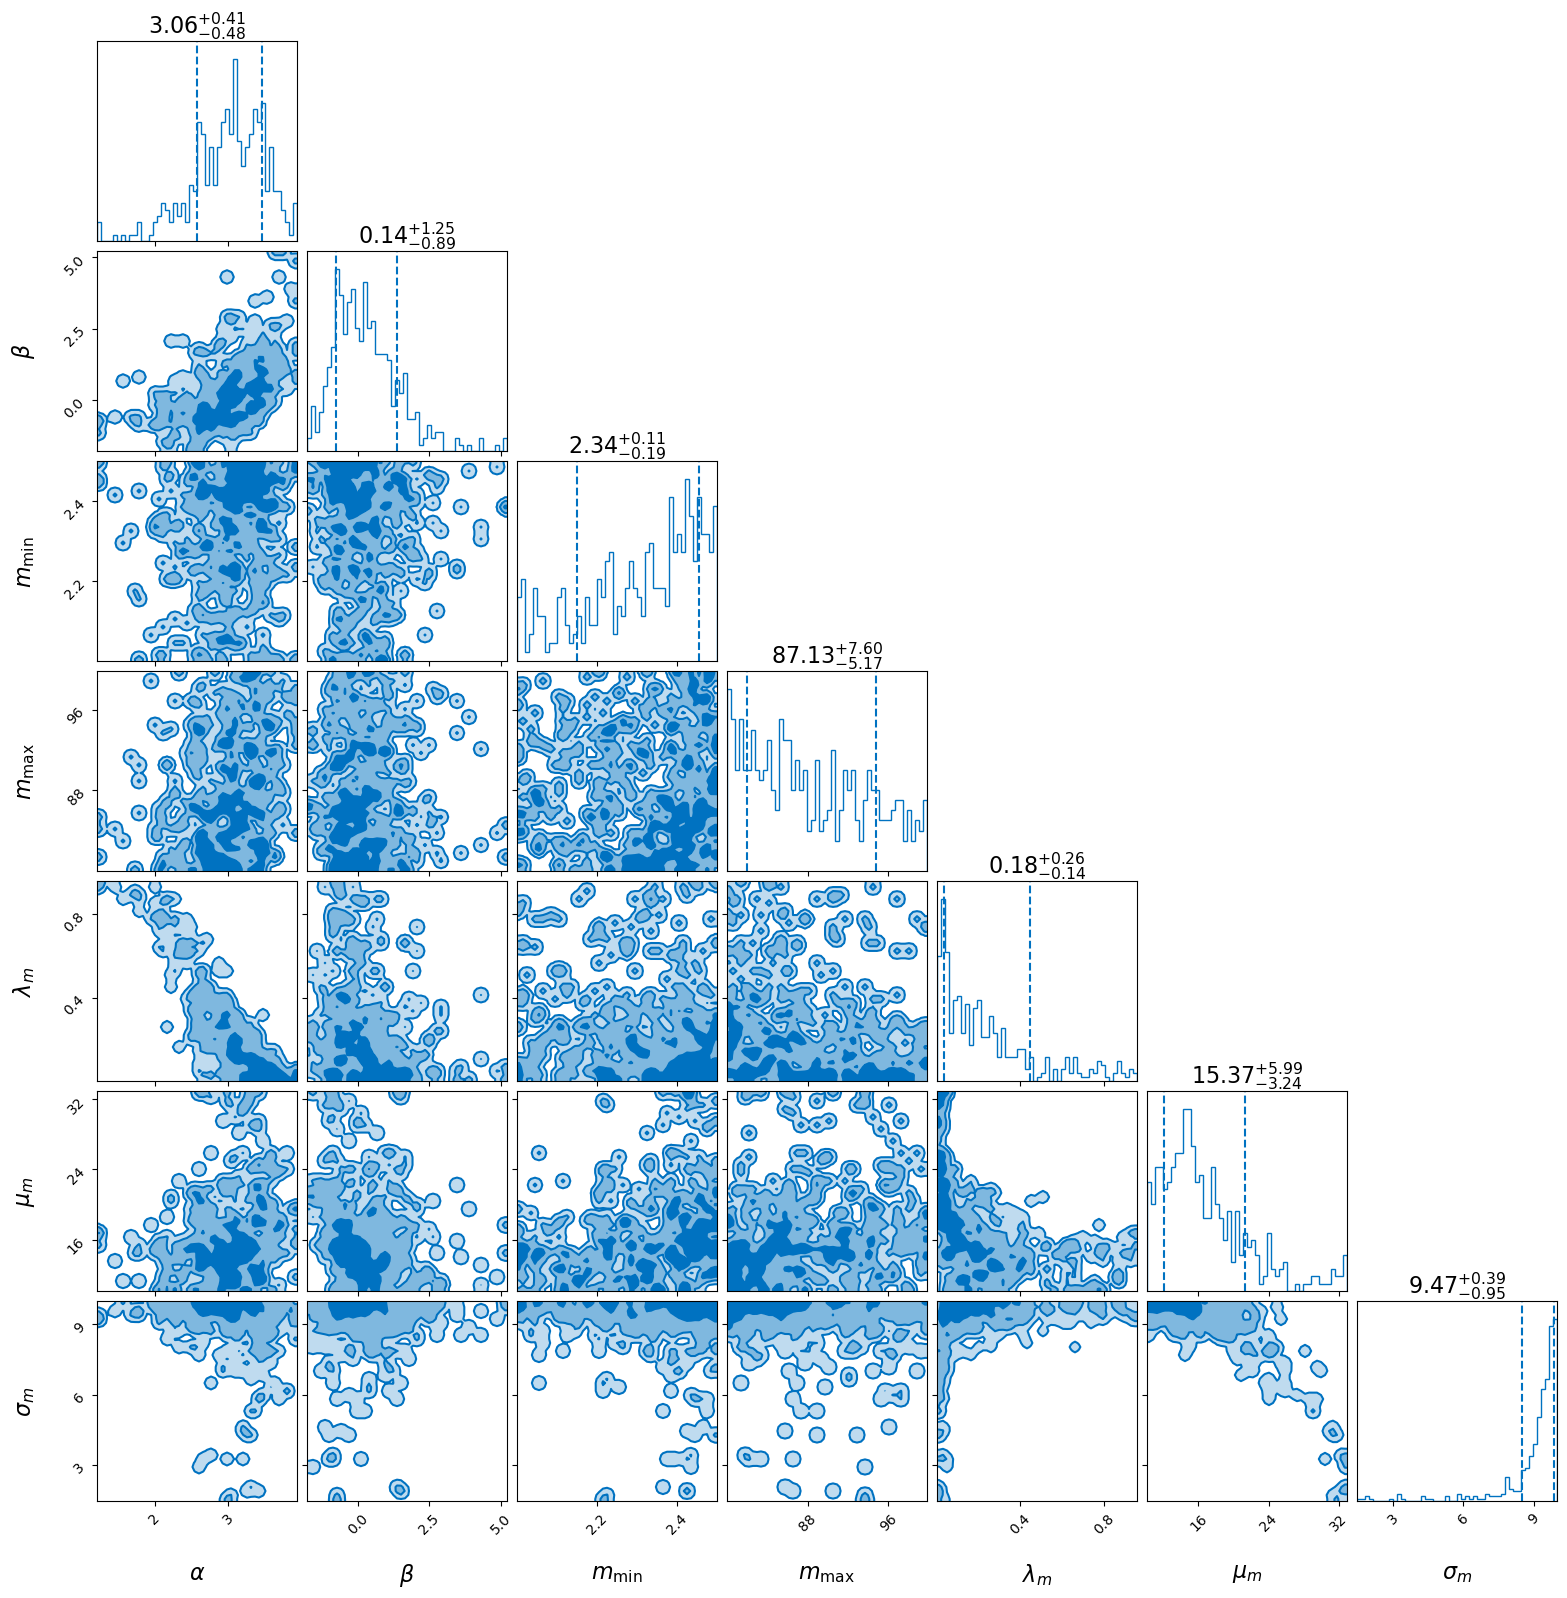

In [15]:
_ = result.plot_corner(save=False, parameters=["alpha", "beta", "mmin", "mmax", "lam", "mpp", "sigpp"])